**Libraries**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.utils import save_image
import numpy as np
from PIL import Image
import os
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision import models

# Building Generator

In [18]:
# Generator model (U-Net for SAR to RGB translation)
# Define the downsampling block
class DownSample(nn.Module):
    def __init__(self, in_channels, out_channels, apply_batchnorm=True):
        super(DownSample, self).__init__()
        layers = [
            nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1, bias=False)
        ]
        if apply_batchnorm:
            layers.append(nn.BatchNorm2d(out_channels))
        layers.append(nn.LeakyReLU(0.2))
        self.block = nn.Sequential(*layers)

    def forward(self, x):
        return self.block(x)

# Define the upsampling block
class Upsample(nn.Module):
    def __init__(self, in_channels, out_channels, apply_dropout=False):
        super(Upsample, self).__init__()
        layers = [
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        ]
        if apply_dropout:
            layers.append(nn.Dropout(0.5))
        self.block = nn.Sequential(*layers)

    def forward(self, x, skip_input):
        x = self.block(x)
        x = torch.cat((x, skip_input), 1)
        return x

# Generator adapted for SAR images
class Generator(nn.Module):
    def __init__(self, in_channels=1, out_channels=3):  # 1 input channel (SAR), 3 output channels (RGB)
        super(Generator, self).__init__()
        self.down1 = DownSample(in_channels, 64)
        self.down2 = DownSample(64, 128)
        self.down3 = DownSample(128, 256)
        self.down4 = DownSample(256, 512)
        self.down5 = DownSample(512, 512)
        self.down6 = DownSample(512, 512)
        self.down7 = DownSample(512, 512)
        self.down8 = DownSample(512, 512)

        self.up1 = Upsample(512, 512)
        self.up2 = Upsample(1024, 512)
        self.up3 = Upsample(1024, 512)
        self.up4 = Upsample(1024, 512)
        self.up5 = Upsample(1024, 256)
        self.up6 = Upsample(512, 128)
        self.up7 = Upsample(256, 64)

        self.final = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.ZeroPad2d((1, 0, 1, 0)),
            nn.Conv2d(128, out_channels, kernel_size=4, padding=1),  # 3 output channels (RGB)
            nn.Tanh(),
        )

    def forward(self, x):
        # U-NET generator with skip connections from encoder to decoder
        d1 = self.down1(x)
        d2 = self.down2(d1)
        d3 = self.down3(d2)
        d4 = self.down4(d3)
        d5 = self.down5(d4)
        d6 = self.down6(d5)
        d7 = self.down7(d6)
        d8 = self.down8(d7)

        u1 = self.up1(d8, d7)
        u2 = self.up2(u1, d6)
        u3 = self.up3(u2, d5)
        u4 = self.up4(u3, d4)
        u5 = self.up5(u4, d3)
        u6 = self.up6(u5, d2)
        u7 = self.up7(u6, d1)
        u8 = self.final(u7)

        return u8


# **Building Discriminator**

In [19]:
class Discriminator(nn.Module):
    def __init__(self, in_channels=4):
        super(Discriminator, self).__init__()
        def discriminator_block(in_filters, out_filters, stride=2, normalize=True):
            """Returns layers of each discriminator block"""
            layers = [nn.Conv2d(in_filters, out_filters, kernel_size=4, stride=stride, padding=1)]
            if normalize:
                layers.append(nn.BatchNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *discriminator_block(in_channels, 64, normalize=False),
            *discriminator_block(64, 128),
            *discriminator_block(128, 256),
            *discriminator_block(256, 512, stride=1),
            nn.Conv2d(512, 1, kernel_size=4, padding=1)
        )

    def forward(self, img_A, img_B):
        # Concatenate image and condition image by channels to produce input
        img_input = torch.cat((img_A, img_B), 1)
        return self.model(img_input)

# **Defining Loss Functions**

In [20]:
criterion_GAN = nn.MSELoss()
criterion_pixelwise = nn.L1Loss()

# Chromatic Aberration Loss definition
class ChromaticAberrationLoss(nn.Module):
    def __init__(self, lambda_color=1.0, lambda_spatial=1.0, lambda_perceptual=1.0, lambda_edge=1.0):
        super(ChromaticAberrationLoss, self).__init__()
        self.lambda_color = lambda_color
        self.lambda_spatial = lambda_spatial
        self.lambda_perceptual = lambda_perceptual
        self.lambda_edge = lambda_edge

        # Pre-trained VGG19 model for perceptual loss
        vgg19 = models.vgg19(pretrained=True).features
        self.vgg19_block4_conv4 = nn.Sequential(*list(vgg19[:21])).eval()  # Block 4 conv 4
        for param in self.vgg19_block4_conv4.parameters():
            param.requires_grad = False

    # Convert from RGB to YUV (PyTorch version)
    def rgb_to_yuv(self, image):
        r, g, b = image[:, 0:1], image[:, 1:1], image[:, 2:1]
        y = 0.299 * r + 0.587 * g + 0.114 * b
        u = -0.14713 * r - 0.28886 * g + 0.436 * b
        v = 0.615 * r - 0.51499 * g - 0.10001 * b
        return torch.cat([y, u, v], dim=1)

    # 1. Color Discrepancy Loss (L2 Norm in YUV space)
    def color_loss(self, y_true, y_pred):
        y_true_yuv = self.rgb_to_yuv(y_true)
        y_pred_yuv = self.rgb_to_yuv(y_pred)
        return torch.mean((y_true_yuv - y_pred_yuv) ** 2)

    # 2. Spatial Consistency Loss (L1 Norm between neighboring pixels)
    def spatial_loss(self, image):
        loss_vertical = torch.mean(torch.abs(image[:, :, :-1, :] - image[:, :, 1:, :]))
        loss_horizontal = torch.mean(torch.abs(image[:, :, :, :-1] - image[:, :, :, 1:]))
        return loss_vertical + loss_horizontal

    # 3. Perceptual Loss (using VGG19)
    def perceptual_loss(self, y_true, y_pred):
        y_true_vgg = self.vgg19_block4_conv4(y_true)
        y_pred_vgg = self.vgg19_block4_conv4(y_pred)
        return torch.mean((y_true_vgg - y_pred_vgg) ** 2)

    # 4. Edge-Aware Loss (gradient difference in edge areas)
    def edge_aware_loss(self, y_true, y_pred):
        grad_true_x = y_true[:, :, 1:, :] - y_true[:, :, :-1, :]
        grad_true_y = y_true[:, :, :, 1:] - y_true[:, :, :, :-1]
        grad_pred_x = y_pred[:, :, 1:, :] - y_pred[:, :, :-1, :]
        grad_pred_y = y_pred[:, :, :, 1:] - y_pred[:, :, :, :-1]

        edge_loss = torch.mean(torch.abs(grad_true_x - grad_pred_x)) + \
                    torch.mean(torch.abs(grad_true_y - grad_pred_y))
        return edge_loss

    # Total Chromatic Aberration Loss
    def forward(self, y_true, y_pred):
        color_loss_value = self.color_loss(y_true, y_pred)
        spatial_loss_value = self.spatial_loss(y_pred)
        perceptual_loss_value = self.perceptual_loss(y_true, y_pred)
        edge_loss_value = self.edge_aware_loss(y_true, y_pred)

        total_loss = (self.lambda_color * color_loss_value) + \
                     (self.lambda_spatial * spatial_loss_value) + \
                     (self.lambda_perceptual * perceptual_loss_value) + \
                     (self.lambda_edge * edge_loss_value)

        return total_loss


# Optimizers and Transforms

In [21]:
# Initialize generator and discriminator
generator = Generator()
discriminator = Discriminator()

# Optimizers
optimizer_G = optim.Adam(generator.parameters(), lr=0.002, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.002, betas=(0.5, 0.999))

# Transforms
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

# Dataset class for handling SAR input and DATALOADER

In [22]:
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os
import torchvision.transforms as transforms

# Define the dataset class
class ImageDataset(Dataset):
    def __init__(self, SAR_root, color_root=None, transforms_=None):
        self.SAR_root = SAR_root
        self.color_root = color_root
        self.transforms = transforms_
        self.SAR_images = [f for f in os.listdir(SAR_root) if f.endswith('.png')]  # Adjust as necessary

    def __len__(self):
        return len(self.SAR_images)

    def __getitem__(self, idx):
        SAR_image_path = os.path.join(self.SAR_root, self.SAR_images[idx])
        SAR_image = Image.open(SAR_image_path).convert('L')  # Convert to grayscale (1 channel)

        if self.color_root:
            color_image_path = os.path.join(self.color_root, self.SAR_images[idx])
            color_image = Image.open(color_image_path).convert('RGB')  # Convert to RGB (3 channels)
            if self.transforms:
                SAR_image = self.transforms(SAR_image)
                color_image = self.transforms(color_image)
            return SAR_image, color_image
        else:
            if self.transforms:
                SAR_image = self.transforms(SAR_image)
            return SAR_image

# Define the transformations
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Adjust to match your model input size
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Adjust normalization as needed
])

# DataLoader for training
dataloader = DataLoader(
    ImageDataset(
        SAR_root="/content/drive/MyDrive/prototype/Train/x",
        color_root="/content/drive/MyDrive/prototype/Train/y",
        transforms_=transform
    ),
    batch_size=16,
    shuffle=True
)


In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

generator = generator.to(device)
discriminator = discriminator.to(device)

# Training

In [25]:
import time
import torch
import torch.nn.functional as F
from tqdm import tqdm

# Initialize custom Chromatic Aberration Loss function
chromatic_loss_fn = ChromaticAberrationLoss(lambda_color=1.0, lambda_spatial=1.0, lambda_perceptual=1.0, lambda_edge=1.0)

# Paths to save the best models
save_path_generator = '/content/drive/MyDrive/prototype/Models/generator/generator.pth'
save_path_discriminator = '/content/drive/MyDrive/prototype/Models/discriminator/discriminator.pth'

# Early stopping parameters
patience = 5
best_loss_G = float('inf')
best_loss_D = float('inf')
no_improvement_G = 0
no_improvement_D = 0

# Get the total number of batches
total_batches = len(dataloader)

# Start the training loop
for epoch in range(200):
    start_time = time.time()  # Record start time for ETA calculation
    epoch_loss_G = 0
    epoch_loss_D = 0

    dataloader_tqdm = tqdm(dataloader, desc=f'Epoch {epoch+1}/200', leave=False)

    for i, (SAR_imgs, color_imgs) in enumerate(dataloader_tqdm):
        SAR_imgs = SAR_imgs.to(device)
        color_imgs = color_imgs.to(device)

        valid = torch.ones((SAR_imgs.size(0), 1, 1, 1), requires_grad=False).to(device)
        fake = torch.zeros((SAR_imgs.size(0), 1, 1, 1), requires_grad=False).to(device)

        # ------------------
        # Train Generator
        # ------------------
        optimizer_G.zero_grad()

        fake_imgs = generator(SAR_imgs)
        # Resize fake images to match color images size if necessary
        fake_imgs_resized = F.interpolate(fake_imgs, size=color_imgs.size()[2:], mode='bilinear', align_corners=False)

        # Ensure that fake_imgs_resized and color_imgs have the same size
        assert fake_imgs_resized.size() == color_imgs.size(), f"Size mismatch: {fake_imgs_resized.size()} vs {color_imgs.size()}"

        # GAN loss (Discriminator should classify fake images as valid)
        loss_GAN = criterion_GAN(discriminator(fake_imgs_resized, SAR_imgs), valid)

        # Chromatic Aberration Loss
        loss_chromatic = chromatic_loss_fn(color_imgs, fake_imgs_resized)

        # Total generator loss
        loss_G = loss_GAN + loss_chromatic
        loss_G.backward()
        optimizer_G.step()

        # ------------------
        # Train Discriminator
        # ------------------
        optimizer_D.zero_grad()

        # Real images (Discriminator should classify real images as valid)
        loss_real = criterion_GAN(discriminator(color_imgs, SAR_imgs), valid)

        # Fake images (Discriminator should classify generated images as fake)
        loss_fake = criterion_GAN(discriminator(fake_imgs_resized.detach(), SAR_imgs), fake)

        # Total discriminator loss
        loss_D = 0.5 * (loss_real + loss_fake)
        loss_D.backward()
        optimizer_D.step()

        epoch_loss_G += loss_G.item()
        epoch_loss_D += loss_D.item()

        # Calculate elapsed time and ETA
        elapsed_time = time.time() - start_time
        avg_time_per_batch = elapsed_time / (i + 1)
        remaining_batches = total_batches - (i + 1)
        eta = avg_time_per_batch * remaining_batches

        # Update the tqdm description with ETA
        dataloader_tqdm.set_postfix({
            'D loss': f'{loss_D.item():.4f}',
            'G loss': f'{loss_G.item():.4f}',
            'ETA': f'{eta:.2f}s'
        })

    # Calculate average loss for the epoch
    avg_loss_G = epoch_loss_G / len(dataloader)
    avg_loss_D = epoch_loss_D / len(dataloader)

    print(f"\n[Epoch {epoch+1}/200] [Avg D loss: {avg_loss_D:.4f}] [Avg G loss: {avg_loss_G:.4f}]")
    print(f"Elapsed Time: {elapsed_time:.2f} seconds | ETA: {eta:.2f} seconds")

    # Early stopping and model checkpointing
    if avg_loss_G < best_loss_G:
        best_loss_G = avg_loss_G
        no_improvement_G = 0
        best_generator_state = generator.state_dict()
    else:
        no_improvement_G += 1

    if avg_loss_D < best_loss_D:
        best_loss_D = avg_loss_D
        no_improvement_D = 0
        best_discriminator_state = discriminator.state_dict()
    else:
        no_improvement_D += 1

    # Check for early stopping
    if no_improvement_G >= patience and no_improvement_D >= patience:
        print("Early stopping triggered. Training stopped.")
        break

# Save the final best models
torch.save(best_generator_state, save_path_generator)
torch.save(best_discriminator_state, save_path_discriminator)

print("Training complete. Best models saved.")


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/prototype/Train/y/ROIs1970_fall_s1_2_p44.png'

# Testing


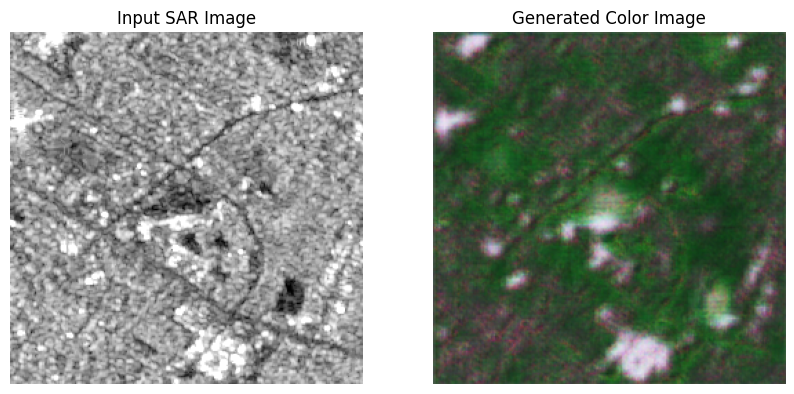

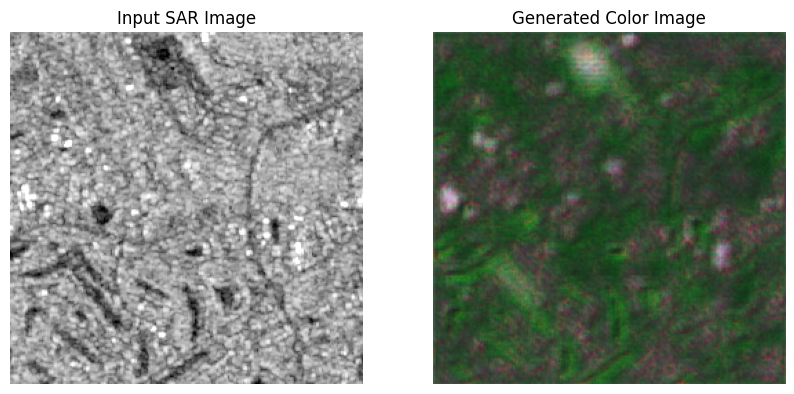

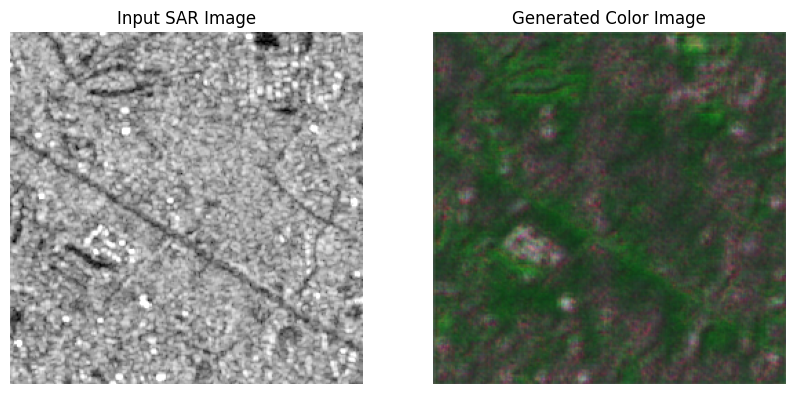

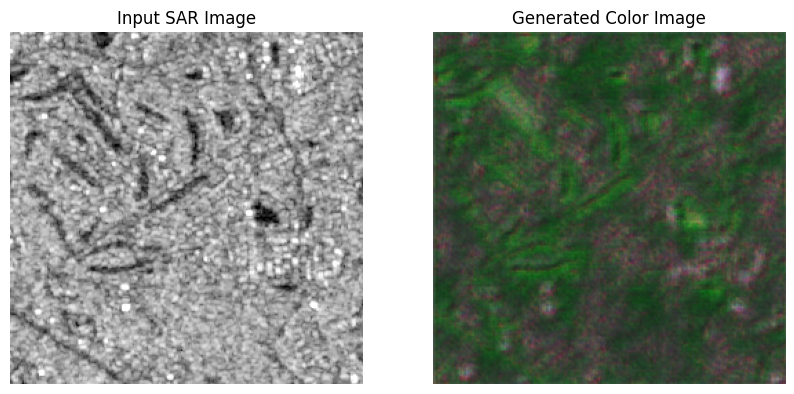

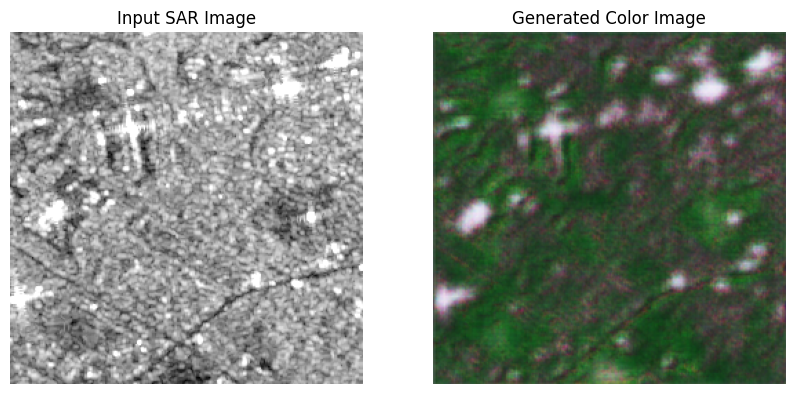

In [31]:
# Load test dataset for inference
test_dataset = ImageDataset(
    SAR_root="/content/drive/MyDrive/prototype/Test",
    color_root=None,  # Not needed for testing
    transforms_=transform
)

test_dataloader = DataLoader(
    test_dataset,
    batch_size=16,
    shuffle=False
)

# Function to test the generator and display images
def test_generator(generator, test_loader, num_images=5):
    generator.eval()  # Set the generator to evaluation mode
    with torch.no_grad():  # Disable gradient calculation for faster inference
        for i, SAR_imgs in enumerate(test_loader):
            SAR_imgs = SAR_imgs.to(device)  # Move SAR images to the device
            generated_imgs = generator(SAR_imgs)
            generated_imgs = 0.5 * (generated_imgs + 1)  # Denormalize from [-1, 1] to [0, 1]
            SAR_imgs = SAR_imgs.cpu()
            generated_imgs = generated_imgs.cpu()

            # Display the first few images in the batch
            for j in range(min(num_images, SAR_imgs.size(0))):
                fig, axes = plt.subplots(1, 2, figsize=(10, 5))

                # Input SAR image
                axes[0].imshow(SAR_imgs[j].squeeze(0), cmap='gray')  # Display as grayscale
                axes[0].set_title('Input SAR Image')
                axes[0].axis('off')

                # Output colorized image
                axes[1].imshow(transforms.ToPILImage()(generated_imgs[j]))
                axes[1].set_title('Generated Color Image')
                axes[1].axis('off')

                plt.show()

# Run testing and visualization
test_generator(generator, test_dataloader, num_images=5)